# Preparation

In [2]:
#Import needed libraries & packages
import h5py, cv2, io, os, random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from google.colab import drive

In [ ]:
# Splitting image folders into train, val, test folders (once via ipynb)
input_folder = "D:\\Users\\Administrator\\Downloads\\towing"
output = "C:\\Users\\Dimas Ahmad\\Downloads\\KP CNN\\dataset towing"

splitfolders.ratio(input_folder, output=output, seed=2022, ratio=(.7, .15, .15))

Copying files: 208 files [00:12, 17.19 files/s]


In [3]:
# Mount google drive and set current directory
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/KP CNN

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/KP CNN


In [4]:
#Set directories path
base_dir = "/content/drive/My Drive/Colab Notebooks/KP CNN/dataset towing"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_0_dir = os.path.join(train_dir, 'Ekspor')
train_1_dir = os.path.join(train_dir, 'Lokal')

validation_0_dir = os.path.join(validation_dir, 'Ekspor')
validation_1_dir = os.path.join(validation_dir, 'Lokal')

test_0_dir = os.path.join(test_dir, 'Ekspor')
test_1_dir = os.path.join(test_dir, 'Lokal')

In [5]:
#Check total images per classes per sets
print('total training ekspor images:', len(os.listdir(train_0_dir)))
print('total training lokal images:', len(os.listdir(train_1_dir)))

print('total validation ekspor images:', len(os.listdir(validation_0_dir)))
print('total validation lokal images:', len(os.listdir(validation_1_dir)))

print('total testing ekspor images:', len(os.listdir(test_0_dir)))
print('total testing lokal images:', len(os.listdir(test_1_dir)))

total training ekspor images: 92
total training lokal images: 53
total validation ekspor images: 19
total validation lokal images: 11
total testing ekspor images: 21
total testing lokal images: 12


In [6]:
# Preparing zero-valued Numpy array for cut objects
# Shape: image number, height, width, number of channels
x_train = np.zeros((1, 64, 64, 3))

# Preparing temp zero-valued Numpy array for current cut object
# Shape: image number, height, width, number of channels
x_temp = np.zeros((1, 64, 64, 3))

# Defining boolean variable to track arrays' shapes
first_object = True


os.chdir('/content/drive/My Drive/Colab Notebooks/KP CNN/dataset towing/train/Ekspor')
# Showing currently active directory
print('Currently active directory:')
print(os.getcwd())
print()

for current_dir, dirs, files in os.walk('.', topdown = True):
    # Iterating all files
    for f in files:
        image_array = cv2.imread(f)
        # Swapping channels from BGR to RGB by OpenCV function
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_array = cv2.resize(image_array, (64, 64), interpolation=cv2.INTER_CUBIC)
        # Checking if it is the first object
        if first_object:
            # Assigning to the first position first object
            x_train[0, :, :, :] = image_array
            first_object = False
            # Collecting next objects into temp arrays
            # Concatenating arrays vertically
        else:
            # Assigning to temp array current object
            x_temp[0, :, :, :] = image_array
            # Concatenating vertically temp arrays to main arrays
            x_train = np.concatenate((x_train, x_temp), axis=0)


os.chdir('/content/drive/My Drive/Colab Notebooks/KP CNN/dataset towing/train/Lokal')
# Showing currently active directory
print('Currently active directory:')
print(os.getcwd())
print()

for current_dir, dirs, files in os.walk('.', topdown = True):
    # Iterating all files
    for f in files:
        image_array = cv2.imread(f)
        # Swapping channels from BGR to RGB by OpenCV function
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_array = cv2.resize(image_array, (64, 64), interpolation=cv2.INTER_CUBIC)
        x_temp[0, :, :, :] = image_array
        # Concatenating vertically temp arrays to main arrays
        x_train = np.concatenate((x_train, x_temp), axis=0)

print(x_train.shape)
os.chdir('/content/drive/My Drive/Colab Notebooks/KP CNN')

Currently active directory:
/content/drive/My Drive/Colab Notebooks/KP CNN/dataset towing/train/Ekspor

Currently active directory:
/content/drive/My Drive/Colab Notebooks/KP CNN/dataset towing/train/Lokal

(145, 64, 64, 3)


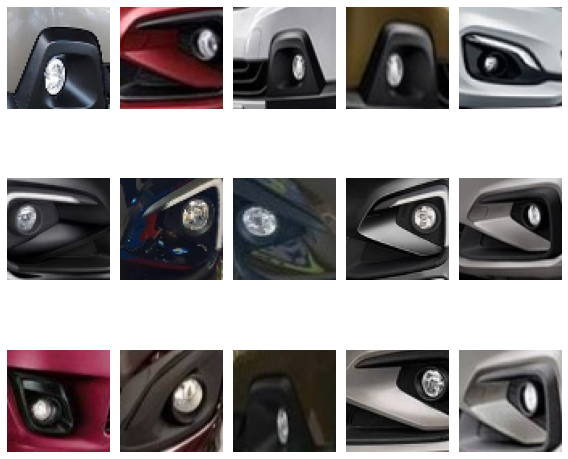

In [7]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (8, 8)


# Defining a figure object with number of needed subplots
# ax is a (3, 5) numpy array
# To access specific subplot we call it by ax[0, 0]
figure, ax = plt.subplots(nrows=3, ncols=5)


# Plotting 15 examples along 3 rows and 5 columns
for i in range(3):
    for j in range(5):
        # Preparing random index
        ii = np.random.randint(low=0, high=x_train.shape[0])
        
        # Plotting current subplot
        ax[i, j].imshow(x_train[ii].astype('uint8'))
                
        # Hiding axis
        ax[i, j].axis('off')

# Adjusting distance between subplots
plt.tight_layout()

# Showing the plot
plt.show()

# Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.1, horizontal_flip=True, brightness_range = [0.7, 1.1], featurewise_center=True, featurewise_std_normalization=True)
val_datagen = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True)

train_datagen.fit(x_train)
val_datagen.fit(x_train)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(64, 64),  # All images will be resized to 64x64
        batch_size=15,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=15,
        class_mode='binary')

Found 145 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [32]:
print(x_train.mean())
print(x_train.std())

print(train_datagen.mean)
print(train_datagen.std)

77.17018173042385
66.89540763614467
[[[0.31565222 0.2950085  0.29845235]]]
[[[0.2633547  0.26055202 0.262549  ]]]


# Eksperimen

## How Many ConvPool Pairs?

### Build Models to Evaluate 

In [10]:
# Model ConvPool Pair (CPP) 1: RGB --> {8C3-P2} --> 128 --> 1
# Model ConvPool Pair (CPP) 2: RGB --> {8C3-P2} --> {16C3-P2} --> 128 --> 1
# Model ConvPool Pair (CPP) 3: RGB --> {8C3-P2} --> {16C3-P2} --> {32C3-P2} --> 128 --> 1
# Model ConvPool Pair (CPP) 4: RGB --> {8C3-P2} --> {16C3-P2} --> {32C3-P2} --> {64C3-P2} --> 128 --> 1

img_input = layers.Input(shape=(64, 64, 3))

# Building 1st CPP Model
x = layers.Conv2D(8, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_cpp_1 = Model(img_input, output)
model_cpp_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


# Building 2nd CPP Model
x = layers.Conv2D(8, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_cpp_2 = Model(img_input, output)
model_cpp_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


# Building 3rd CPP Model
x = layers.Conv2D(8, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_cpp_3 = Model(img_input, output)
model_cpp_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


# Building 4th CPP Model
x = layers.Conv2D(8, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_cpp_4 = Model(img_input, output)
model_cpp_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model_cpp = [model_cpp_1, model_cpp_2, model_cpp_3, model_cpp_4]

### Train Built Models 

In [11]:
print(" ")
print("TRAINING 1st Model")
print(" ")
history_cpp_1 = model_cpp_1.fit(train_generator, steps_per_epoch=10, epochs=24, validation_data=validation_generator, validation_steps=2, verbose=1)
print(" ")
print("TRAINING 2nd Model")
print(" ")
history_cpp_2 = model_cpp_2.fit(train_generator, steps_per_epoch=10, epochs=24, validation_data=validation_generator, validation_steps=2, verbose=1)
print(" ")
print("TRAINING 3rd Model")
print(" ")
history_cpp_3 = model_cpp_3.fit(train_generator, steps_per_epoch=10, epochs=24, validation_data=validation_generator, validation_steps=2, verbose=1)
print(" ")
print("TRAINING 4th Model")
print(" ")
history_cpp_4 = model_cpp_4.fit(train_generator, steps_per_epoch=10, epochs=24, validation_data=validation_generator, validation_steps=2, verbose=1)

 
TRAINING 1st Model
 
Epoch 1/24
10/10 [==============================] - 29s 2s/step - loss: 0.7290 - acc: 0.6000 - val_loss: 0.6007 - val_acc: 0.6333
Epoch 2/24
10/10 [==============================] - 1s 62ms/step - loss: 0.6369 - acc: 0.6759 - val_loss: 0.5773 - val_acc: 0.6333
Epoch 3/24
10/10 [==============================] - 1s 63ms/step - loss: 0.5625 - acc: 0.7172 - val_loss: 0.5564 - val_acc: 0.6667
Epoch 4/24
10/10 [==============================] - 1s 64ms/step - loss: 0.5247 - acc: 0.7793 - val_loss: 0.4183 - val_acc: 0.8667
Epoch 5/24
10/10 [==============================] - 1s 64ms/step - loss: 0.5103 - acc: 0.7586 - val_loss: 0.4753 - val_acc: 0.8000
Epoch 6/24
10/10 [==============================] - 1s 63ms/step - loss: 0.4991 - acc: 0.7379 - val_loss: 0.3846 - val_acc: 0.8333
Epoch 7/24
10/10 [==============================] - 1s 63ms/step - loss: 0.4953 - acc: 0.7793 - val_loss: 0.4182 - val_acc: 0.8667
Epoch 8/24
10/10 [==============================] - 1s 62ms/s

### Evaluate (Visualization) 

In [12]:
# Accuracies of the 1st model
print('Model 1: Max Training accuracy= {0:.5f}, Max Validation accuracy= {1:.5f}, Max Training loss= {2:.5f}, Max Validation loss= {3:.5f}'.
                                                           format(max(history_cpp_1.history['acc']),
                                                                  max(history_cpp_1.history['val_acc']),
                                                                  max(history_cpp_1.history['loss']),
                                                                  max(history_cpp_1.history['val_loss'])))
print('Model 2: Max Training accuracy= {0:.5f}, Max Validation accuracy= {1:.5f}, Max Training loss= {2:.5f}, Max Validation loss= {3:.5f}'.
                                                           format(max(history_cpp_2.history['acc']),
                                                                  max(history_cpp_2.history['val_acc']),
                                                                  max(history_cpp_2.history['loss']),
                                                                  max(history_cpp_2.history['val_loss'])))
print('Model 3: Max Training accuracy= {0:.5f}, Max Validation accuracy= {1:.5f}, Max Training loss= {2:.5f}, Max Validation loss= {3:.5f}'.
                                                           format(max(history_cpp_3.history['acc']),
                                                                  max(history_cpp_3.history['val_acc']),
                                                                  max(history_cpp_3.history['loss']),
                                                                  max(history_cpp_3.history['val_loss'])))
print('Model 4: Max Training accuracy= {0:.5f}, Max Validation accuracy= {1:.5f}, Max Training loss= {2:.5f}, Max Validation loss= {3:.5f}'.
                                                           format(max(history_cpp_4.history['acc']),
                                                                  max(history_cpp_4.history['val_acc']),
                                                                  max(history_cpp_4.history['loss']),
                                                                  max(history_cpp_4.history['val_loss'])))

Model 1: Max Training accuracy= 0.93793, Max Validation accuracy= 0.93333, Max Training loss= 0.72903, Max Validation loss= 0.60070
Model 2: Max Training accuracy= 0.95172, Max Validation accuracy= 0.93333, Max Training loss= 0.65060, Max Validation loss= 0.79968
Model 3: Max Training accuracy= 0.93103, Max Validation accuracy= 0.96667, Max Training loss= 0.67880, Max Validation loss= 0.64796
Model 4: Max Training accuracy= 0.91724, Max Validation accuracy= 0.86667, Max Training loss= 0.65980, Max Validation loss= 0.68972


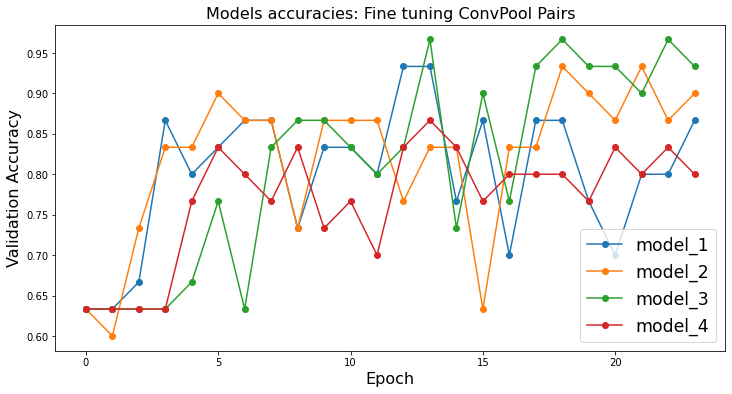

In [13]:
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# Plotting accuracies for every model
plt.plot(history_cpp_1.history['val_acc'], '-o')
plt.plot(history_cpp_2.history['val_acc'], '-o')
plt.plot(history_cpp_3.history['val_acc'], '-o')
plt.plot(history_cpp_4.history['val_acc'], '-o')

# Showing legend
plt.legend(['model_1', 'model_2', 'model_3', 'model_4'], loc='lower right', fontsize='xx-large')

# Giving name to axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)

# Giving name to the plot
plt.title('Models accuracies: Fine tuning ConvPool Pairs', fontsize=16)

# Showing the plot
plt.show()

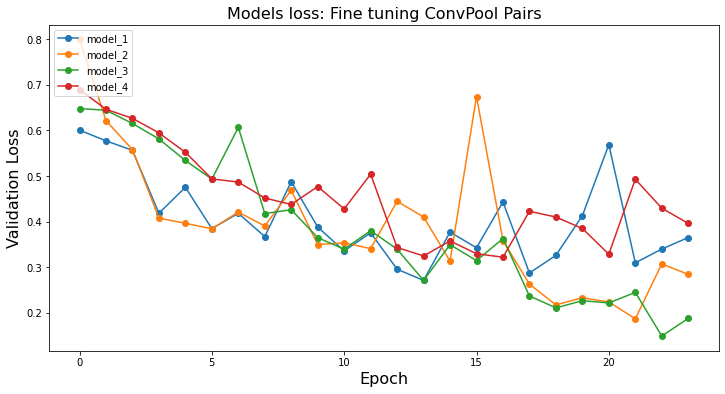

In [14]:
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# Plotting accuracies for every model
plt.plot(history_cpp_1.history['val_loss'], '-o')
plt.plot(history_cpp_2.history['val_loss'], '-o')
plt.plot(history_cpp_3.history['val_loss'], '-o')
plt.plot(history_cpp_4.history['val_loss'], '-o')

# Showing legend
plt.legend(['model_1', 'model_2', 'model_3', 'model_4'], loc='upper left')

# Giving name to axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Validation Loss', fontsize=16)

# Giving name to the plot
plt.title('Models loss: Fine tuning ConvPool Pairs', fontsize=16)

# Showing the plot
plt.show()

### Best Convolutional-Pooling Pairs: Model 3 (3 Pairs)

RGB --> {8C3-P2} --> {16C3-P2} --> {32C3-P2} --> 128 --> 1

## Feature Maps?

### Build Models to Evaluate 

In [15]:
# Model FM 1: RGB --> {8C3-P2} --> {16C3-P2} --> {32C3-P2} --> 128 --> 1
# Model FM 2: RGB --> {16C3-P2} --> {32C3-P2} --> {64C3-P2} --> 128 --> 1
# Model FM 3: RGB --> {32C3-P2} --> {64C3-P2} --> {128C3-P2} --> 128 --> 1
# Model FM 4: RGB --> {64C3-P2} --> {128C3-P2} --> {256C3-P2} --> 128 --> 1
# Model FM 5: RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2} --> 128 --> 1

# Defining list to collect models in
model_FM = []

# Building models in a loop
for i in range(5):
  x = layers.Conv2D(8*(2**i), 3, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Conv2D(16*(2**i), 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Conv2D(32*(2**i), 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  output = layers.Dense(1, activation='sigmoid')(x)

  temp = Model(img_input, output)
  temp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  # Adding current model in the list
  model_FM.append(temp)

### Train Built Models 

In [16]:
# Defining list to collect results in
history_FM = []

# Training models in a loop
for i in range(5):
    print(" ")
    print(f"TRAINING Model FM {i+1}")
    print(" ")
    temp = model_FM[i].fit(train_generator, steps_per_epoch=10, epochs=24, validation_data=validation_generator, validation_steps=2, verbose=1)
    history_FM.append(temp)

 
TRAINING Model FM 1
 
Epoch 1/24
10/10 [==============================] - 1s 82ms/step - loss: 0.6595 - acc: 0.6138 - val_loss: 0.6288 - val_acc: 0.6333
Epoch 2/24
10/10 [==============================] - 1s 64ms/step - loss: 0.6298 - acc: 0.6345 - val_loss: 0.5989 - val_acc: 0.6333
Epoch 3/24
10/10 [==============================] - 1s 59ms/step - loss: 0.5866 - acc: 0.7379 - val_loss: 0.5540 - val_acc: 0.6000
Epoch 4/24
10/10 [==============================] - 1s 62ms/step - loss: 0.5380 - acc: 0.7103 - val_loss: 0.5109 - val_acc: 0.8667
Epoch 5/24
10/10 [==============================] - 1s 62ms/step - loss: 0.5230 - acc: 0.7862 - val_loss: 0.4438 - val_acc: 0.8667
Epoch 6/24
10/10 [==============================] - 1s 66ms/step - loss: 0.4884 - acc: 0.7862 - val_loss: 0.4146 - val_acc: 0.8333
Epoch 7/24
10/10 [==============================] - 1s 60ms/step - loss: 0.4407 - acc: 0.8207 - val_loss: 0.5432 - val_acc: 0.7000
Epoch 8/24
10/10 [==============================] - 1s 62ms

### Evaluate (Visualization) 

In [17]:
for i in range(5):
    print('Model FM {0}: MAX Training accuracy= {1:.5f}, MAX Validation accuracy= {2:.5f}, MAX Training loss= {3:.5f}, MAX Validation loss= {4:.5f}'.
                                                         format(i + 1,
                                                                max(history_FM[i].history['acc']),
                                                                max(history_FM[i].history['val_acc']),
                                                                max(history_FM[i].history['loss']),
                                                                max(history_FM[i].history['val_loss']),))

Model FM 1: MAX Training accuracy= 0.91724, MAX Validation accuracy= 0.93333, MAX Training loss= 0.65955, MAX Validation loss= 0.62883
Model FM 2: MAX Training accuracy= 0.95172, MAX Validation accuracy= 0.93333, MAX Training loss= 0.68185, MAX Validation loss= 0.64923
Model FM 3: MAX Training accuracy= 0.96552, MAX Validation accuracy= 0.96667, MAX Training loss= 0.68496, MAX Validation loss= 0.65974
Model FM 4: MAX Training accuracy= 0.96552, MAX Validation accuracy= 0.93333, MAX Training loss= 0.68591, MAX Validation loss= 0.64335
Model FM 5: MAX Training accuracy= 0.95862, MAX Validation accuracy= 1.00000, MAX Training loss= 0.69282, MAX Validation loss= 0.66431


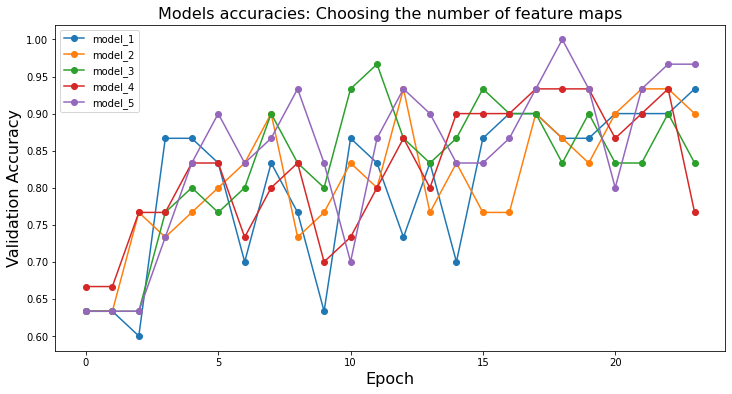

In [18]:
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# Plotting accuracies for every model
plt.plot(history_FM[0].history['val_acc'], '-o')
plt.plot(history_FM[1].history['val_acc'], '-o')
plt.plot(history_FM[2].history['val_acc'], '-o')
plt.plot(history_FM[3].history['val_acc'], '-o')
plt.plot(history_FM[4].history['val_acc'], '-o')

# Showing legend
plt.legend(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'])

# Giving name to axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)

# Giving name to the plot
plt.title('Models accuracies: Choosing the number of feature maps', fontsize=16)

# Showing the plot
plt.show()

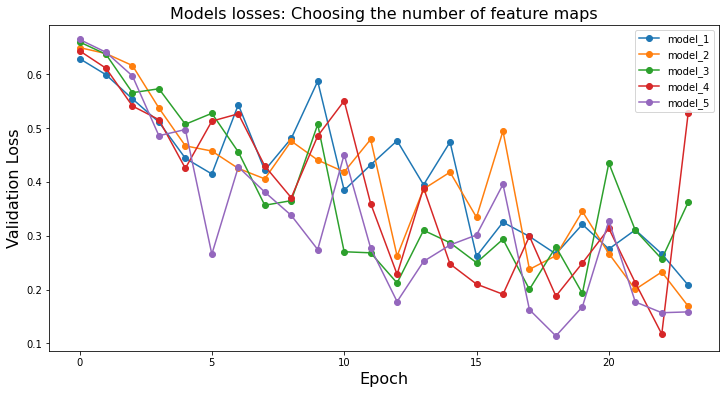

In [19]:
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# Plotting accuracies for every model
plt.plot(history_FM[0].history['val_loss'], '-o')
plt.plot(history_FM[1].history['val_loss'], '-o')
plt.plot(history_FM[2].history['val_loss'], '-o')
plt.plot(history_FM[3].history['val_loss'], '-o')
plt.plot(history_FM[4].history['val_loss'], '-o')

# Showing legend
plt.legend(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'])

# Giving name to axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Validation Loss', fontsize=16)

# Giving name to the plot
plt.title('Models losses: Choosing the number of feature maps', fontsize=16)

# Showing the plot
plt.show()

### Best number of feature maps combination:

RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2} --> 128 --> 1

## How Many Neurons in Output Layers?

### Build Models to Evaluate 

In [20]:
# Model Neurons in Output Layers (NOL) 1: RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2} --> 128 --> 1
# Model NOL 2: RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2}  --> 256 --> 1
# Model NOL 3: RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2}  --> 512 --> 1
# Model NOL 4: RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2}  --> 1024 --> 1
# Model NOL 5: RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2}  --> 2048 --> 1

model_nol = []

for i in range(5):
  x = layers.Conv2D(128, 3, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Conv2D(256, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Conv2D(512, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Flatten()(x)
  x = layers.Dense(128*(2**i), activation='relu')(x)
  output = layers.Dense(1, activation='sigmoid')(x)

  temp = Model(img_input, output)
  temp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  # Adding current model in the list
  model_nol.append(temp)

### Train Built Models 

In [21]:
# Defining list to collect results in
history_nol = []

# Training models in a loop
for i in range(5):
  print(" ")
  print(f"TRAINING Model NOL {i+1}")
  print(" ")
  temp = model_nol[i].fit(train_generator, steps_per_epoch=10, epochs=24, validation_data=validation_generator, validation_steps=2, verbose=1)
  history_nol.append(temp)

 
TRAINING Model NOL 1
 
Epoch 1/24
10/10 [==============================] - 2s 107ms/step - loss: 0.7387 - acc: 0.6000 - val_loss: 0.6680 - val_acc: 0.6333
Epoch 2/24
10/10 [==============================] - 1s 76ms/step - loss: 0.6594 - acc: 0.6345 - val_loss: 0.6652 - val_acc: 0.6333
Epoch 3/24
10/10 [==============================] - 1s 74ms/step - loss: 0.6347 - acc: 0.6345 - val_loss: 0.6294 - val_acc: 0.6333
Epoch 4/24
10/10 [==============================] - 1s 77ms/step - loss: 0.5887 - acc: 0.6345 - val_loss: 0.5948 - val_acc: 0.7000
Epoch 5/24
10/10 [==============================] - 1s 75ms/step - loss: 0.5368 - acc: 0.7586 - val_loss: 0.7227 - val_acc: 0.5667
Epoch 6/24
10/10 [==============================] - 1s 77ms/step - loss: 0.6286 - acc: 0.6345 - val_loss: 0.5806 - val_acc: 0.6333
Epoch 7/24
10/10 [==============================] - 1s 73ms/step - loss: 0.5440 - acc: 0.6690 - val_loss: 0.4546 - val_acc: 0.8333
Epoch 8/24
10/10 [==============================] - 1s 73

### Evaluate (Visualization) 

In [22]:
for i in range(5):
    print('Model NOL {0}: MAX Training accuracy= {1:.5f}, MAX Validation accuracy= {2:.5f}, MAX Training loss= {3:.5f}, MAX Validation loss= {4:.5f}'.
          format(i + 1, max(history_nol[i].history['acc']), max(history_nol[i].history['val_acc']),
                 max(history_nol[i].history['loss']), max(history_nol[i].history['val_loss'])))

Model NOL 1: MAX Training accuracy= 0.95862, MAX Validation accuracy= 0.93333, MAX Training loss= 0.73871, MAX Validation loss= 0.72274
Model NOL 2: MAX Training accuracy= 0.92414, MAX Validation accuracy= 0.96667, MAX Training loss= 0.79407, MAX Validation loss= 0.66456
Model NOL 3: MAX Training accuracy= 0.96552, MAX Validation accuracy= 0.93333, MAX Training loss= 0.78099, MAX Validation loss= 0.76644
Model NOL 4: MAX Training accuracy= 0.96552, MAX Validation accuracy= 0.96667, MAX Training loss= 0.80112, MAX Validation loss= 1.08594
Model NOL 5: MAX Training accuracy= 0.95172, MAX Validation accuracy= 0.93333, MAX Training loss= 0.81895, MAX Validation loss= 0.67296


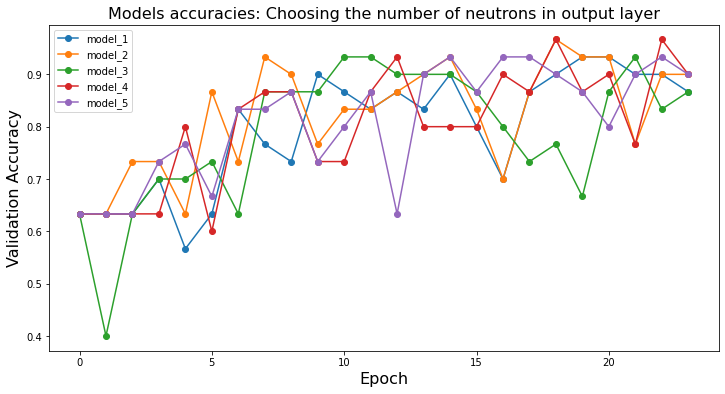

In [23]:
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# Plotting accuracies for every model
plt.plot(history_nol[0].history['val_acc'], '-o')
plt.plot(history_nol[1].history['val_acc'], '-o')
plt.plot(history_nol[2].history['val_acc'], '-o')
plt.plot(history_nol[3].history['val_acc'], '-o')
plt.plot(history_nol[4].history['val_acc'], '-o')

# Showing legend
plt.legend(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'])

# Giving name to axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)

# Giving name to the plot
plt.title('Models accuracies: Choosing the number of neutrons in output layer', fontsize=16)

# Showing the plot
plt.show()

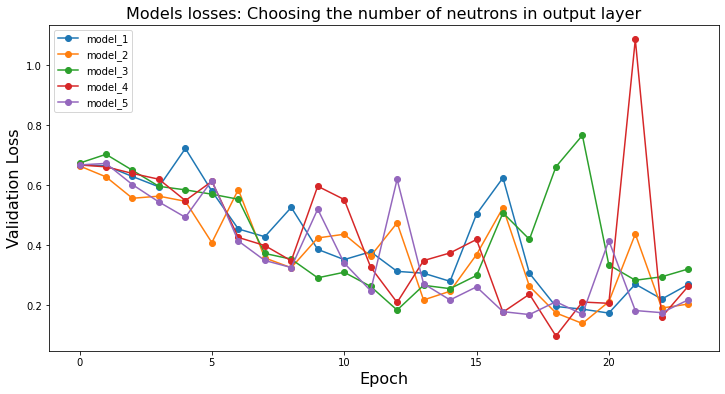

In [24]:
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# Plotting accuracies for every model
plt.plot(history_nol[0].history['val_loss'], '-o')
plt.plot(history_nol[1].history['val_loss'], '-o')
plt.plot(history_nol[2].history['val_loss'], '-o')
plt.plot(history_nol[3].history['val_loss'], '-o')
plt.plot(history_nol[4].history['val_loss'], '-o')

# Showing legend
plt.legend(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'])

# Giving name to axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Validation Loss', fontsize=16)

# Giving name to the plot
plt.title('Models losses: Choosing the number of neutrons in output layer', fontsize=16)

# Showing the plot
plt.show()

### Best number of neurons in output layer: 256 (Model 2)

RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2} --> 256 --> 1

## Best Preprocessing Method?

### Build Generator to Evaluate 

In [25]:
# Generator 1: Pixel Scaling with normalization (1/255)
# Generator 2: Pixel scaling with centering (- mean image)
# Generator 3: Pixel scaling with standardizing (/ std image)

#Building generator 1
train_datagen_1 = ImageDataGenerator(rescale=1./255, zoom_range=0.1, horizontal_flip=True, brightness_range = [0.7, 1.1])
val_datagen_1 = ImageDataGenerator(rescale=1./255)

train_generator_1 = train_datagen_1.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(64, 64),  # All images will be resized to 64x64
        batch_size=15,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator_1 = val_datagen_1.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=15,
        class_mode='binary')



#Building generator 2
train_datagen_2 = ImageDataGenerator(rescale=1./255, zoom_range=0.1, horizontal_flip=True, brightness_range = [0.7, 1.1], featurewise_center=True)
val_datagen_2 = ImageDataGenerator(rescale=1./255, featurewise_center=True)

train_datagen_2.fit(x_train)
val_datagen_2.fit(x_train)

train_generator_2 = train_datagen_2.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(64, 64),  # All images will be resized to 64x64
        batch_size=15,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator_2 = val_datagen_2.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=15,
        class_mode='binary')



#Building generator 3
train_datagen_3 = ImageDataGenerator(rescale=1./255, zoom_range=0.1, horizontal_flip=True, brightness_range = [0.7, 1.1],
                                     featurewise_center=True, featurewise_std_normalization=True)
val_datagen_3 = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True)

train_datagen_3.fit(x_train)
val_datagen_3.fit(x_train)

train_generator_3 = train_datagen_3.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(64, 64),  # All images will be resized to 64x64
        batch_size=15,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator_3 = val_datagen_3.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=15,
        class_mode='binary')

Found 145 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 145 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 145 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [26]:
#Building model: RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2} --> 256 --> 1
model_gen = []
for i in range(3):
  x = layers.Conv2D(128, 3, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Conv2D(256, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Conv2D(512, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  
  x = layers.Flatten()(x)
  x = layers.Dense(256, activation='relu')(x)
  output = layers.Dense(1, activation='sigmoid')(x)

  temp = Model(img_input, output)
  temp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  # Adding current model in the list
  model_gen.append(temp)

### Train Built Models 

In [27]:
print(" ")
print(f"TRAINING WITH NORMALIZED DATA")
print(" ")
history_gen_1 = model_gen[0].fit(train_generator_1, steps_per_epoch=10, epochs=24, validation_data=validation_generator_1, validation_steps=2, verbose=1)

print(" ")
print(f"TRAINING WITH CENTRALIZED DATA")
print(" ")
history_gen_2 = model_gen[1].fit(train_generator_2, steps_per_epoch=10, epochs=24, validation_data=validation_generator_2, validation_steps=2, verbose=1)

print(" ")
print(f"TRAINING WITH STANDARDIZED DATA")
print(" ")
history_gen_3 = model_gen[2].fit(train_generator_3, steps_per_epoch=10, epochs=24, validation_data=validation_generator_3, validation_steps=2, verbose=1)

 
TRAINING WITH NORMALIZED DATA
 
Epoch 1/24
10/10 [==============================] - 1s 96ms/step - loss: 0.8694 - acc: 0.5379 - val_loss: 0.6831 - val_acc: 0.6333
Epoch 2/24
10/10 [==============================] - 1s 77ms/step - loss: 0.6661 - acc: 0.6345 - val_loss: 0.6607 - val_acc: 0.6333
Epoch 3/24
10/10 [==============================] - 1s 77ms/step - loss: 0.6420 - acc: 0.6345 - val_loss: 0.6871 - val_acc: 0.6333
Epoch 4/24
10/10 [==============================] - 1s 75ms/step - loss: 0.6126 - acc: 0.6483 - val_loss: 0.6213 - val_acc: 0.7667
Epoch 5/24
10/10 [==============================] - 1s 75ms/step - loss: 0.5932 - acc: 0.7103 - val_loss: 0.6218 - val_acc: 0.5667
Epoch 6/24
10/10 [==============================] - 1s 78ms/step - loss: 0.5988 - acc: 0.6897 - val_loss: 0.6040 - val_acc: 0.6333
Epoch 7/24
10/10 [==============================] - 1s 81ms/step - loss: 0.5612 - acc: 0.7172 - val_loss: 0.5458 - val_acc: 0.7667
Epoch 8/24
10/10 [==============================]

### Evaluate (Visualization) 

In [28]:
print('Normalized Data: Max Training accuracy= {0:.5f}, Max Validation accuracy= {1:.5f}, Max Training loss= {2:.5f}, Max Validation loss= {3:.5f}'.
                                                           format(max(history_gen_1.history['acc']),
                                                                  max(history_gen_1.history['val_acc']),
                                                                  max(history_gen_1.history['loss']),
                                                                  max(history_gen_1.history['val_loss'])))
print('Centralized Data: Max Training accuracy= {0:.5f}, Max Validation accuracy= {1:.5f}, Max Training loss= {2:.5f}, Max Validation loss= {3:.5f}'.
                                                           format(max(history_gen_2.history['acc']),
                                                                  max(history_gen_2.history['val_acc']),
                                                                  max(history_gen_2.history['loss']),
                                                                  max(history_gen_2.history['val_loss'])))
print('Standardized Data: Max Training accuracy= {0:.5f}, Max Validation accuracy= {1:.5f}, Max Training loss= {2:.5f}, Max Validation loss= {3:.5f}'.
                                                           format(max(history_gen_3.history['acc']),
                                                                  max(history_gen_3.history['val_acc']),
                                                                  max(history_gen_3.history['loss']),
                                                                  max(history_gen_3.history['val_loss'])))

Normalized Data: Max Training accuracy= 0.95172, Max Validation accuracy= 0.90000, Max Training loss= 0.86937, Max Validation loss= 0.68711
Centralized Data: Max Training accuracy= 0.96552, Max Validation accuracy= 0.93333, Max Training loss= 0.67815, Max Validation loss= 0.67211
Standardized Data: Max Training accuracy= 0.98621, Max Validation accuracy= 0.93333, Max Training loss= 0.89109, Max Validation loss= 0.65591


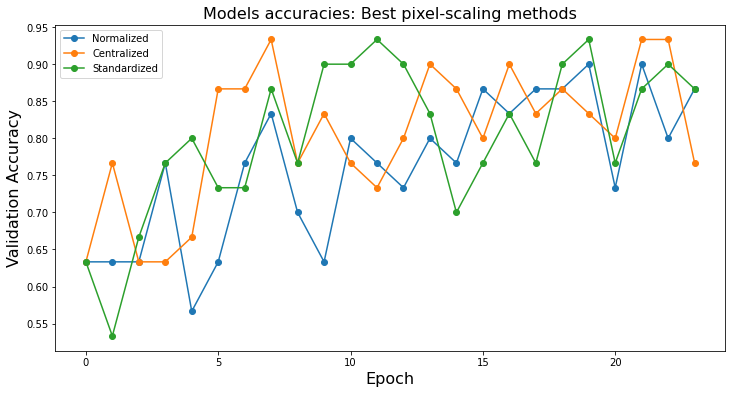

In [29]:
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# Plotting accuracies for every model
plt.plot(history_gen_1.history['val_acc'], '-o')
plt.plot(history_gen_2.history['val_acc'], '-o')
plt.plot(history_gen_3.history['val_acc'], '-o')

# Showing legend
plt.legend(['Normalized', 'Centralized', 'Standardized'])

# Giving name to axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)

# Giving name to the plot
plt.title('Models accuracies: Best pixel-scaling methods', fontsize=16)

# Showing the plot
plt.show()

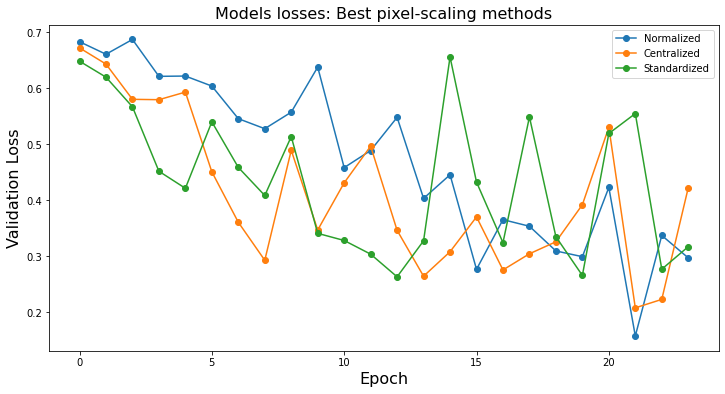

In [30]:
%matplotlib inline

# Setting default size of the plot
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# Plotting accuracies for every model
plt.plot(history_gen_1.history['val_loss'], '-o')
plt.plot(history_gen_2.history['val_loss'], '-o')
plt.plot(history_gen_3.history['val_loss'], '-o')

# Showing legend
plt.legend(['Normalized', 'Centralized', 'Standardized'])

# Giving name to axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Validation Loss', fontsize=16)

# Giving name to the plot
plt.title('Models losses: Best pixel-scaling methods', fontsize=16)

# Showing the plot
plt.show()

### Best pixel-scaling method: 

Standardizing (feature-wise)

## Best Model Architecture:

RGB --> {128C3-P2} --> {256C3-P2} --> {512C3-P2} --> 256 --> 1

With feature-wised standardized data ((x/255 - avg)/std)

# Data Modeling & Processing

Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `adam` optimizer. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

## Building Model

In [35]:
# Our input feature map is 64x64x3: 64x64 for the image pixels, and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=(64, 64, 3))

# First convolution extracts 128 filters that are 3x3, convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 256 filters that are 3x3, convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 512 filters that are 3x3, convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(512, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers  
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 128 hidden units
x = layers.Dense(256, activation='relu')(x)

# Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully connected layer + sigmoid output layer
model = Model(img_input, output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('best_model_towing.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 31, 31, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 29, 29, 256)       295168    
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 12, 12, 512)       118

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

## Training

In [36]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,  # 145 images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=2,  # 30 images = batch_size * steps
      verbose=2, callbacks=[es, mc])

Epoch 1/50

Epoch 1: val_acc improved from -inf to 0.63333, saving model to best_model_towing.h5
10/10 - 2s - loss: 0.9133 - acc: 0.5172 - val_loss: 0.6647 - val_acc: 0.6333 - 2s/epoch - 222ms/step
Epoch 2/50

Epoch 2: val_acc did not improve from 0.63333
10/10 - 1s - loss: 0.6757 - acc: 0.6000 - val_loss: 0.6558 - val_acc: 0.6333 - 736ms/epoch - 74ms/step
Epoch 3/50

Epoch 3: val_acc did not improve from 0.63333
10/10 - 1s - loss: 0.6367 - acc: 0.6345 - val_loss: 0.6616 - val_acc: 0.6333 - 718ms/epoch - 72ms/step
Epoch 4/50

Epoch 4: val_acc improved from 0.63333 to 0.70000, saving model to best_model_towing.h5
10/10 - 1s - loss: 0.6208 - acc: 0.7103 - val_loss: 0.5260 - val_acc: 0.7000 - 1s/epoch - 101ms/step
Epoch 5/50

Epoch 5: val_acc did not improve from 0.70000
10/10 - 1s - loss: 0.6003 - acc: 0.6897 - val_loss: 0.5982 - val_acc: 0.6667 - 796ms/epoch - 80ms/step
Epoch 6/50

Epoch 6: val_acc did not improve from 0.70000
10/10 - 1s - loss: 0.5439 - acc: 0.7586 - val_loss: 0.8488 -

## Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Best Model: Max Training accuracy= 0.90345, Max Validation accuracy= 0.96667, Min Training loss= 0.23714, Min Validation loss= 0.16287


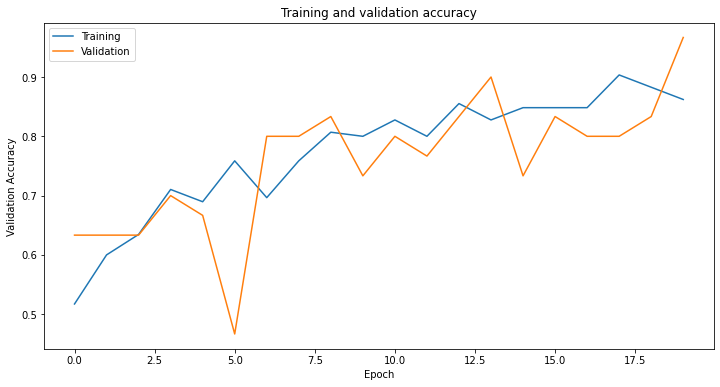

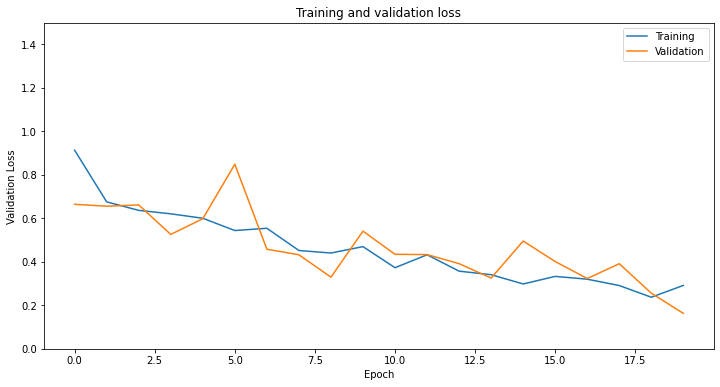

In [37]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc'][:20]
val_acc = history.history['val_acc'][:20]

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss'][:20]
val_loss = history.history['val_loss'][:20]

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
legend_drawn_flag = True
plt.legend(["Training", "Validation"], loc=0, frameon=legend_drawn_flag)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
legend_drawn_flag = True
plt.legend(["Training", "Validation"], loc=0, frameon=legend_drawn_flag)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.title('Training and validation loss')

print('Best Model: Max Training accuracy= {0:.5f}, Max Validation accuracy= {1:.5f}, Min Training loss= {2:.5f}, Min Validation loss= {3:.5f}'
      .format(max(acc), max(val_acc),
              min(loss), min(val_loss)))

## Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


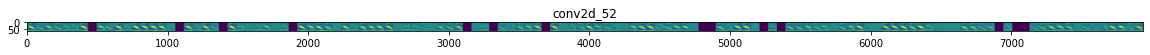

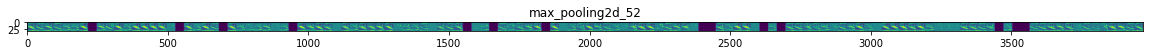

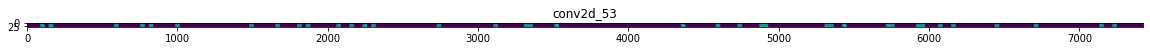

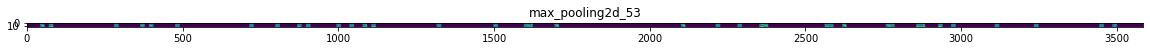

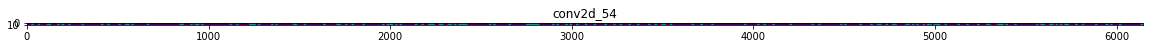

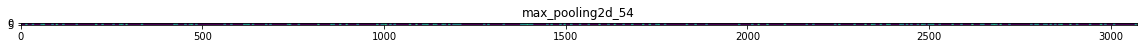

In [38]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
train_0_fnames = os.listdir(train_0_dir)
train_1_fnames = os.listdir(train_1_dir)

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random image from the training set.
ekspor_img_files = [os.path.join(train_0_dir, f) for f in train_0_fnames]
lokal_img_files = [os.path.join(train_1_dir, f) for f in train_1_fnames]
img_path = random.choice(ekspor_img_files + lokal_img_files)

img = load_img(img_path, target_size=(64, 64))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (64, 64, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 64, 64, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

## Testing

In [39]:
# load the saved model
saved_model = load_model('best_model_towing.h5')

In [40]:
# load the test dataset
test_datagen = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # This is the source directory for training images
    target_size=(64, 64),  # All images will be resized to 64x64
    batch_size=1,
    shuffle = False,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 33 images belonging to 2 classes.


In [41]:
#Predicting the test dataset using saved model
pred = model.predict(test_generator, steps = nb_samples)

In [42]:
y_true = test_generator.classes
y_pred = []
for i in pred:
    if i <= 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [43]:
print(classification_report(y_true, y_pred))

c_m = confusion_matrix(y_true, y_pred)
print("Confusion Matrix: ")
print(c_m)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.82      0.75      0.78        12

    accuracy                           0.85        33
   macro avg       0.84      0.83      0.83        33
weighted avg       0.85      0.85      0.85        33

Confusion Matrix: 
[[19  2]
 [ 3  9]]


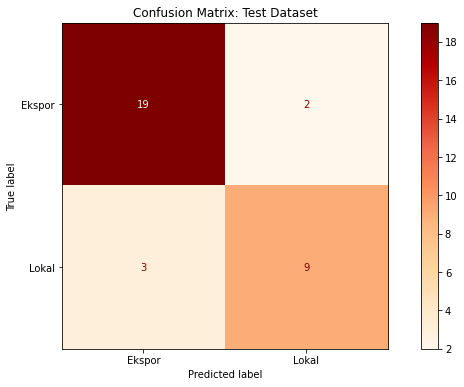

In [45]:
labels = ['Ekspor', 'Lokal']

plt.rcParams['figure.figsize'] = (12,6)

display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)

# Plotting confusion matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd')
# Other possible options for colour map are: 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'

# Giving name to the plot
plt.title('Confusion Matrix: Test Dataset')

# Showing the plot
plt.show()

# Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)